In [76]:
import dask_ml.joblib
from dask.distributed import Client
from sklearn.externals import joblib
from sklearn.datasets import fetch_mldata
from sklearn.linear_model import SGDClassifier
import numpy as np

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

In [77]:
mnist = fetch_mldata('MNIST original')
mnist

{'DESCR': 'mldata.org dataset: mnist-original',
 'COL_NAMES': ['label', 'data'],
 'target': array([0., 0., 0., ..., 9., 9., 9.]),
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)}

In [78]:
X, y = mnist["data"], mnist["target"]
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


In [110]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = matplotlib.cm.binary,
               interpolation="nearest")
    plt.axis("off")
    
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = matplotlib.cm.binary, **options)
    plt.axis("off")

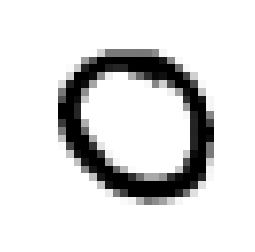

In [111]:
some_digit = X[3000]
plot_digit(some_digit)

In [80]:
# split our data into train & validation sets like good data scientists
TEST_SET_SIZE = 60_000
RANDOM_STATE = 42
X_train, X_test, y_train, y_test = X[:TEST_SET_SIZE], X[TEST_SET_SIZE:], y[:TEST_SET_SIZE], y[TEST_SET_SIZE:]

shuffle_index = np.random.RandomState(RANDOM_STATE).permutation(60_000)

X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

In [81]:
# let's play with Dask
if "client" in locals():
    client.close()
    
client = Client(diagnostics_port=8786, scheduler_port=8785)
client

distributed.comm.tcp - WARNING - Closing dangling stream in <TCP local=tcp://127.0.0.1:41106 remote=tcp://127.0.0.1:8785>


Client Scheduler: tcp://127.0.0.1:8785 Dashboard: http://127.0.0.1:8786/status,Cluster Workers: 4 Cores: 4 Memory: 33.70 GB


In [82]:
%%time
# Binary classifer: Is it a 5?

# create labels just for 5
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

sgd_clf = SGDClassifier(
    random_state=RANDOM_STATE,
    max_iter=100,
)

# NOTE: this will only run on one core since we only have one class
# from the docs: "The number of CPUs to use to do the OVA 
# (One Versus All, for multi-class problems) computation."
with joblib.parallel_backend("dask", scatter=[X_train, y_train_5], scheduler_host='localhost:8785'):
    sgd_clf.fit(X_train, y_train_5)
print(sgd_clf)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=100, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=None, verbose=0, warm_start=False)
CPU times: user 7.08 s, sys: 157 ms, total: 7.24 s
Wall time: 6.92 s


array([5.])

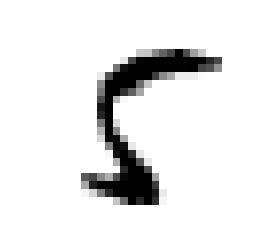

In [118]:
five_idx = np.where(y_train_5 == True)[0][1]
five_digit = X_train[five_idx]
plot_digit(five_digit)
sgd_clf.predict([five_digit])

In [84]:
# Performance Measures

from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3,random_state=RANDOM_STATE)

# "manually" doing cross-validation with stratified kfolds
for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = (y_train_5[train_index])
    X_test_fold = X_train[test_index]
    y_test_fold = (y_train_5[test_index])
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.9625
0.96735
0.9652


In [85]:
from sklearn.model_selection import cross_val_score

# now the easy way
# note this uses stratifiedKFolds under the hood http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html
with joblib.parallel_backend("dask", scatter=[X_train, y_train_5], scheduler_host='localhost:8785'):
    print(cross_val_score(
        sgd_clf,
        X_train,
        y_train_5,
        cv=3,
        scoring="accuracy",
    ))

[0.9625  0.96735 0.9652 ]


In [86]:
# Making an intentionally bad etimator to show that numbers lie

from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)
    
never_5_clf = Never5Classifier()
with joblib.parallel_backend("dask", scatter=[X_train, y_train_5], scheduler_host='localhost:8785'):
    print(cross_val_score(
        never_5_clf,
        X_train,
        y_train_5,
        cv=3,
        scoring="accuracy",
    ))
# we get 90%+ scores because only 10% of our data could possibly be 5s
# ergo accuracy is not a great measure for models

[0.909   0.90715 0.9128 ]


In [87]:
# Confusion Matrix

from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

y_train_pred = cross_val_predict(sgd_clf,X_train,y_train_5,cv=3)
print(y_train_pred.shape)

"""
                         Predicted
                    Negative    Positive
        Negative  [[True neg,   False neg],
Actual
        Positive   [False pos,  True pos]]
"""
confusion_matrix(y_train_5, y_train_pred)


(60000,)


array([[53611,   968],
       [ 1131,  4290]])

In [88]:
# Precision and Recall

# Precision
# TP / (TP + FP)
# How many times were we right when we said something was a 5?

# Recall
# TP / (TP + FN)
# Of the 5s that existed, how many did we correctly guess?

# F1 Score
# A score comprised of both precision & accuracy. Is only high when both are high

# Note that depending on our use case, we may prefer to have 
# higher precision (detecting shoplifting) or higher recall (NSFW classifier)

from sklearn.metrics import precision_score, recall_score, f1_score
print(f"Precision: {precision_score(y_train_5, y_train_pred)}")
print(f"Recall: {recall_score(y_train_5, y_train_pred)}")
print(f"F1: {f1_score(y_train_5, y_train_pred)}")


Precision: 0.8158995815899581
Recall: 0.7913669064748201
F1: 0.8034460155445267


In [89]:
# Precision/Recall Tradeoff

# sklearn also gives us the ability to just return the raw output of 
# decision functions, where we can set our own threshold for classification
some_score = sgd_clf.decision_function([five_digit])
print(some_score)
threshold1 = 0
threshold2 = 20_000
print(some_score > threshold1)
print(some_score > threshold2)

[10952.4068498]
[ True]
[False]


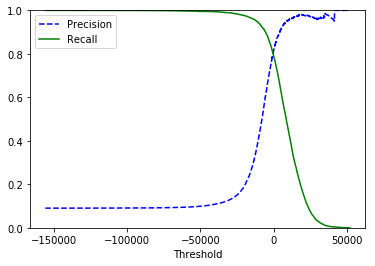

In [90]:
from sklearn.metrics import precision_recall_curve

y_scores = cross_val_predict(
    sgd_clf,
    X_train,
    y_train_5,
    cv=3,
    method="decision_function"
)
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="upper left")
    plt.ylim([0,1])
    
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)


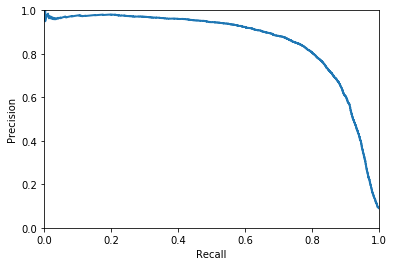

In [91]:
# we can also just plot precision against recall
def plot_precision_recall(precisions, recalls):
    plt.plot(recalls, precisions, linewidth=2, label="Precision")
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.axis([0,1,0,1])

plot_precision_recall(precisions, recalls)

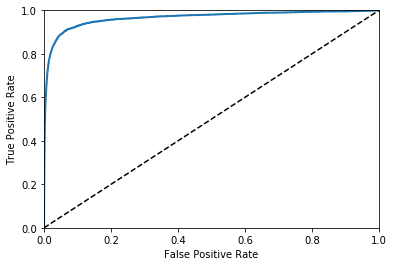

In [92]:
# The ROC Curve
# ROC stands for "receiver operating characteristic"
# which is true positive rate vs false positive rate

from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1],[0,1], "k--")
    plt.axis([0,1,0,1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
plot_roc_curve(fpr, tpr)

In [93]:
from sklearn.metrics import roc_auc_score

# NOTE: rule of thumb - use PR curve when positive class is rare
# or we care more about false positives than false negatives
# use ROC otherwise

# AUC Score or "Area Under the Curve" score of 1 is a perfect model,
# and an auc of .5 is purely random
roc_auc_score(y_train_5, y_scores)


0.9658120874858911

In [94]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=RANDOM_STATE)
with joblib.parallel_backend("dask", scatter=[X_train, y_train_5], scheduler_host='localhost:8785'):
    y_probas_forest = cross_val_predict(
        forest_clf,
        X_train,
        y_train_5,
        cv=3,
        method="predict_proba"
    )

Random Forest AUC: 0.9931243366003829


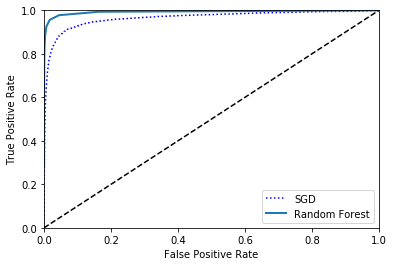

In [95]:
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")

print(f"Random Forest AUC: {roc_auc_score(y_train_5,y_scores_forest)}")

In [96]:
# Multi-class Classification

# sklearn detects when you're doing single vs multiclass. Easy!
# also now dask works as expected because we're doing one-versus-all (OVA)
# instead of one-versus-one (OVO) (for single class and SVMs)
with joblib.parallel_backend("dask", scatter=[X_train, y_train], scheduler_host='localhost:8785'):
    # for some reason dask isn't parallelizing this
    some_digit_scores = sgd_clf.fit(X_train, y_train) # now doing multiclass

In [97]:
print(sgd_clf.predict([five_digit]))
# notice here the highest score is our chosen class
print(sgd_clf.decision_function([five_digit]))
print(sgd_clf.classes_)

[5.]
[[  1692.92018492 -34849.77412644 -19244.39206792 -44305.75638357
  -35920.8104718   10952.4068498  -32024.7879121  -23801.6180984
   -9506.03287898 -21542.61516144]]
[0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]


In [98]:
from sklearn.multiclass import OneVsOneClassifier

# here we can force the use of OVO rather than OVA
ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=RANDOM_STATE, max_iter=50))
ovo_clf.fit(X_train, y_train)
print(len(ovo_clf.estimators_)) # one binary classifer for each digit versus each other digit
ovo_clf.predict([five_digit])

45


array([5.])

In [99]:
forest_clf.fit(X_train, y_train)
print(forest_clf.predict([five_digit]))
print(forest_clf.predict_proba([five_digit]))


[5.]
[[0.  0.  0.  0.  0.  0.9 0.1 0.  0.  0. ]]


In [100]:
# Now that we've trained our multi-class classifiers, let's see how good they are
from sklearn.preprocessing import StandardScaler

with joblib.parallel_backend("dask", scatter=[X_train, y_train]):
    print(cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy"))
    # this is okay, but we can do better just by scaling inputs
    # note that 10% accuracy would be a random guess

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
    print(cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy"))


[0.87267546 0.85169258 0.81547232]
[0.91321736 0.91309565 0.90953643]


[[5695    1   19    9   11   43   45    7   88    5]
 [   1 6472   46   22    6   47    5    9  120   14]
 [  37   32 5355   94   77   27   77   53  194   12]
 [  37   29  135 5356    2  230   30   52  171   89]
 [  15   21   43   11 5341    9   51   30  122  199]
 [  48   34   32  187   58 4601   88   28  256   89]
 [  31   23   49    2   38   95 5598    7   75    0]
 [  22   15   70   30   50   11    6 5788   35  238]
 [  35   98   56  128    6  141   45   14 5240   88]
 [  29   26   34   80  149   35    1  192  132 5271]]


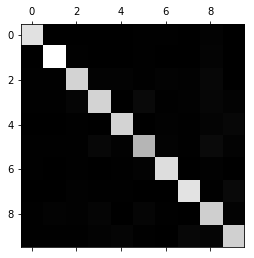

In [104]:
# Error Analysis
with joblib.parallel_backend("dask", scatter=[X_train_scaled, y_train]):
    y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
    conf_mx = confusion_matrix(y_train, y_train_pred)
print(conf_mx)
plt.matshow(conf_mx, cmap=plt.cm.gray)
# this confusion matrix looks pretty good since most of the bright spots are on the diagonal

[[5923]
 [6742]
 [5958]
 [6131]
 [5842]
 [5421]
 [5918]
 [6265]
 [5851]
 [5949]]


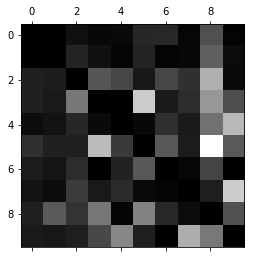

In [107]:
# lets ignore the stuff we got correct and highlight errors
row_sums = conf_mx.sum(axis=1,keepdims=True) # axis 1 is rows, keepdims means don't flatten
norm_conf_mx = conf_mx / row_sums
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
# rememeber that rows are actual classes, cols are predicted classes

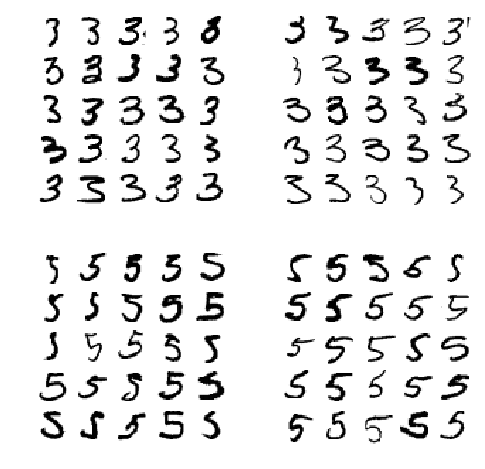

In [113]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

In [121]:
# Multilabel classification
# This is a classifier which outputs a binary vector of all possible classes for each instance

from sklearn.neighbors import KNeighborsClassifier
y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd] # concat along 2nd axis eg ((3,1),(3,1)) > (3,2)

# can't seem to parallelize
knn_clf = KNeighborsClassifier(n_jobs=-1)
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
           weights='uniform')

In [124]:
# correctly predict that 5 is not >= 7, and is odd!
knn_clf.predict([five_digit])

array([[False,  True]])

False